# Single Concentration Test
This is a test run on the AS7341 device where a single cocnentration of 20ug/L was performed to evaluate the performace of the AS7341 device on a single concentration over many trials. 

# Methods
These methods for dilutions can be found at: https://github.com/COAST-Lab/Chlorophyll-Fluorometer-/blob/main/Data%20Analysis/AS7341%20Dilution%20Tests/AS7341_Dilutions_Methods.ipynb

*Note: only the 20ug/L dilution was prepared*

CAD Design can be found at: https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Hardware

## Tests 
3 separate tests were run on the AS7341 device with the 20ug/L sample.

### Cuvette Test with no movement 
The first test run involved filling a cuvette with the 20ug/L solution. Then covering the cuvette holder with a carboard box and running for 1 minute. After the end of the minute the deivce was unplugged and then replugged in and run again. This was done for 10 trials.

### Cuvette Test with movement 
The second test run involved filling a cuvette with the 20ug/L solution. Then covering the cuvette hloder with a carboard box and running for 1 minute. After the end of the minute the deivce was unplugged and the cuvette was taken out and then put back into the cuvetter holder and then replugged in and run again. This was done for 10 trials.

### Cuvette Test with rinse
The second test run involved filling a cuvette with the 20ug/L solution. Then covering the cuvette hloder with a carboard box and running for 1 minute. After the end of the minute the deivce was unplugged and the cuvette was taken out.The cuvette contents were dumped into the sink and then rinsed out 3x with DI water and then 3x with the 20ug/L solution. The cuvette was then filled again with the 20ug/L solution and then put back into the cuvetter holder and then replugged in and run again. This was done for 10 trials.

# Data
Data for these tests can be found at: https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Data%20Analysis/AS7341%20Single%20Concentration%20Test

# Analysis 
This is the code for the analysis for the single concentratin tests of the AS7341

# Cuvette Test with no movement
### Import modules and file paths. Define catagories and create dictionaries 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, t
from sklearn.metrics import r2_score, mean_squared_error

# Replace with the actual file path
file_path = "/Users/jessiewynne/chla_fluorometer/AS7341 Single Concentration Test/1_11_24_700ms_256x_no_movement_1.csv"
# Read the CSV file without skipping any rows

df = pd.read_csv(file_path, encoding='utf-8')

# Filter out rows where the 'Test' column is 'test'
df = df[df['Test'].str.lower() != 'test'] 

# Convert 'F8 (Raw)' column to numeric values
df['F8 (Raw)'] = pd.to_numeric(df['F8 (Raw)'], errors='coerce')

# Get unique test categories (dilution values) in the order of appearance
categories = df['Test'].unique()

# Create a dictionary to store the 'F8 (Raw)' values for each category (dilution)
category_f8_raw_dict = {}

# Create dictionaries to store confidence intervals and ranges of uncertainty
confidence_intervals = {}
uncertainty_ranges = {}

# Initialize mean_blank before the loop
mean_blank = 0.0

# Store unique x-values and their corresponding data points
x_values = []
y_values = []
std_devs = []
cv_values = []

### For catagories complete calcultions 

In [17]:
for category in categories:
    # Exclude the first data point from each category
    category_df = df[df['Test'] == category][1:]
    category_f8_raw_dict[category] = category_df['F8 (Raw)']

    # Calculate the mean and standard deviation for 'F8 (Raw)' data in each category
    category_f8_raw_mean = category_df['F8 (Raw)'].mean()
    category_f8_raw_std = category_df['F8 (Raw)'].std()
    # print(category_f8_raw_mean)
    # Calculate Coefficient of Variation
    cv = (category_f8_raw_std / category_f8_raw_mean) * 100

    # Calculate the sample size for each category
    category_sample_size = len(category_df['F8 (Raw)'])

    # Calculate the standard error for each category's mean
    category_standard_error = category_f8_raw_std / np.sqrt(category_sample_size)

    # Define the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error using the t-distribution
    margin_of_error = t.ppf((1 + confidence_level) / 2, category_sample_size - 1) * category_standard_error

    # Calculate the confidence interval for each category's mean
    confidence_interval = (category_f8_raw_mean - margin_of_error, category_f8_raw_mean + margin_of_error)

    # Calculate the range of uncertainty (95% CI width) for each category
    uncertainty_range = confidence_interval[1] - confidence_interval[0]

    # Check if the 'Test' value can be converted to a float, otherwise, skip it
    try:
        x_value = float(category)
        x_values.append(x_value)
        y_values.append(category_f8_raw_mean)
        std_devs.append(category_f8_raw_std)
        cv_values.append(cv)
    except ValueError:
        pass
# Calculate the mean and standard deviation for the entire dataset for 'F8 (Raw)' data
dataset_f8_raw_mean = df['F8 (Raw)'].mean()
dataset_f8_raw_std = df['F8 (Raw)'].std()

# Calculate the sample size for the entire dataset
dataset_sample_size = len(df['F8 (Raw)'])

# Calculate the standard error for the entire dataset's mean
dataset_standard_error = dataset_f8_raw_std / np.sqrt(dataset_sample_size)

# Calculate the margin of error using the t-distribution
confidence_level = 0.95
margin_of_error = t.ppf((1 + confidence_level) / 2, dataset_sample_size - 1) * dataset_standard_error

# Calculate the confidence interval for the entire dataset's mean
confidence_interval = (dataset_f8_raw_mean - margin_of_error, dataset_f8_raw_mean + margin_of_error)

# Calculate the range of uncertainty (95% CI width) for the entire dataset
uncertainty_range = confidence_interval[1] - confidence_interval[0]

# Calculate the minimum and maximum 'F8 (Raw)' values for each test category
min_f8_values = {}
max_f8_values = {}
for category, f8_raw_values in category_f8_raw_dict.items():
    min_f8_values[category] = f8_raw_values.min()
    max_f8_values[category] = f8_raw_values.max()

### Plot a figure with the mean F8 value for each trial, error bars based on one standard deviation, a line of best fit, Average Coefficient of Variation

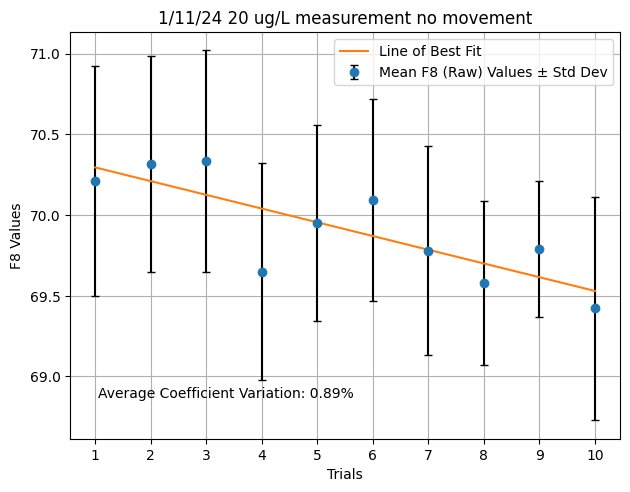

In [18]:
# Scatter plot for mean F8 values with error bars and legend
plt.errorbar(x_values, y_values, yerr=std_devs, fmt='o', capsize=3, ecolor='black', label='Mean F8 (Raw) Values ± Std Dev')

# Calculate the line of best fit parameters (slope and intercept)
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Create a function to calculate predicted values using the line of best fit equation
def predict_values(x, slope, intercept):
    return slope * x + intercept

# Plot the line of best fit
plt.plot(x_values, predict_values(np.array(x_values), slope, intercept), label='Line of Best Fit')

# Display average Coefficient of Variation on the plot
avg_cv = np.mean(cv_values)
plt.annotate(f'Average Coefficient Variation: {avg_cv:.2f}%', xy=(0.05, 0.10), xycoords='axes fraction')

# # Calculate R-squared and RMSE
# y_predicted = predict_values(np.array(x_values), slope, intercept)
# r_squared = r2_score(y_values, y_predicted)
# rmse = np.sqrt(mean_squared_error(y_values, y_predicted))

# Set x-axis tick positions at intervals of 1
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1))

# # Display R-squared and RMSE on the plot
# plt.annotate(f'R-squared: {r_squared:.4f}\nRMSE: {rmse:.4f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()

plt.xlabel('Trials')
plt.ylabel('F8 Values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("1/11/24 20 ug/L measurement no movement")
plt.show()

### Repeat this analysis with the Cuvette Test with Movement and Cuvette Test with Rinse tests

### Cuvette Test with Movement

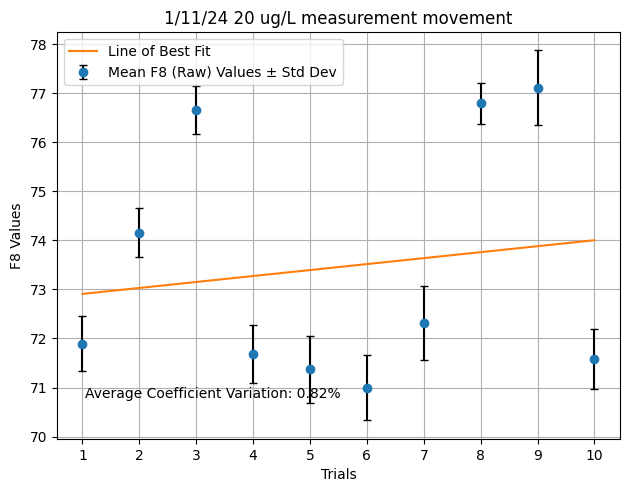

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, t
from sklearn.metrics import r2_score, mean_squared_error

# Replace with the actual file path
file_path = "/Users/jessiewynne/chla_fluorometer/AS7341 Single Concentration Test/1_11_24_700ms_256x_movement_1.csv"
# Read the CSV file without skipping any rows

df = pd.read_csv(file_path, encoding='utf-8')

# Filter out rows where the 'Test' column is 'test'
df = df[df['Test'].str.lower() != 'test'] 

# Convert 'F8 (Raw)' column to numeric values
df['F8 (Raw)'] = pd.to_numeric(df['F8 (Raw)'], errors='coerce')

# Get unique test categories (dilution values) in the order of appearance
categories = df['Test'].unique()

# Create a dictionary to store the 'F8 (Raw)' values for each category (dilution)
category_f8_raw_dict = {}

# Create dictionaries to store confidence intervals and ranges of uncertainty
confidence_intervals = {}
uncertainty_ranges = {}

# Initialize mean_blank before the loop
mean_blank = 0.0

# Store unique x-values and their corresponding data points
x_values = []
y_values = []
std_devs = []
cv_values = []

for category in categories:
    # Exclude the first data point from each category
    category_df = df[df['Test'] == category][1:]
    category_f8_raw_dict[category] = category_df['F8 (Raw)']

    # Calculate the mean and standard deviation for 'F8 (Raw)' data in each category
    category_f8_raw_mean = category_df['F8 (Raw)'].mean()
    category_f8_raw_std = category_df['F8 (Raw)'].std()
    # print(category_f8_raw_mean)
    # Calculate Coefficient of Variation
    cv = (category_f8_raw_std / category_f8_raw_mean) * 100

    # Calculate the sample size for each category
    category_sample_size = len(category_df['F8 (Raw)'])

    # Calculate the standard error for each category's mean
    category_standard_error = category_f8_raw_std / np.sqrt(category_sample_size)

    # Define the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error using the t-distribution
    margin_of_error = t.ppf((1 + confidence_level) / 2, category_sample_size - 1) * category_standard_error

    # Calculate the confidence interval for each category's mean
    confidence_interval = (category_f8_raw_mean - margin_of_error, category_f8_raw_mean + margin_of_error)

    # Calculate the range of uncertainty (95% CI width) for each category
    uncertainty_range = confidence_interval[1] - confidence_interval[0]

    # Check if the 'Test' value can be converted to a float, otherwise, skip it
    try:
        x_value = float(category)
        x_values.append(x_value)
        y_values.append(category_f8_raw_mean)
        std_devs.append(category_f8_raw_std)
        cv_values.append(cv)
    except ValueError:
        pass
# Calculate the mean and standard deviation for the entire dataset for 'F8 (Raw)' data
dataset_f8_raw_mean = df['F8 (Raw)'].mean()
dataset_f8_raw_std = df['F8 (Raw)'].std()

# Calculate the sample size for the entire dataset
dataset_sample_size = len(df['F8 (Raw)'])

# Calculate the standard error for the entire dataset's mean
dataset_standard_error = dataset_f8_raw_std / np.sqrt(dataset_sample_size)

# Calculate the margin of error using the t-distribution
confidence_level = 0.95
margin_of_error = t.ppf((1 + confidence_level) / 2, dataset_sample_size - 1) * dataset_standard_error

# Calculate the confidence interval for the entire dataset's mean
confidence_interval = (dataset_f8_raw_mean - margin_of_error, dataset_f8_raw_mean + margin_of_error)

# Calculate the range of uncertainty (95% CI width) for the entire dataset
uncertainty_range = confidence_interval[1] - confidence_interval[0]

# Calculate the minimum and maximum 'F8 (Raw)' values for each test category
min_f8_values = {}
max_f8_values = {}
for category, f8_raw_values in category_f8_raw_dict.items():
    min_f8_values[category] = f8_raw_values.min()
    max_f8_values[category] = f8_raw_values.max()

# Scatter plot for mean F8 values with error bars and legend
plt.errorbar(x_values, y_values, yerr=std_devs, fmt='o', capsize=3, ecolor='black', label='Mean F8 (Raw) Values ± Std Dev')

# Calculate the line of best fit parameters (slope and intercept)
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Create a function to calculate predicted values using the line of best fit equation
def predict_values(x, slope, intercept):
    return slope * x + intercept

# Plot the line of best fit
plt.plot(x_values, predict_values(np.array(x_values), slope, intercept), label='Line of Best Fit')

# Display average Coefficient of Variation on the plot
avg_cv = np.mean(cv_values)
plt.annotate(f'Average Coefficient Variation: {avg_cv:.2f}%', xy=(0.05, 0.10), xycoords='axes fraction')

# # Calculate R-squared and RMSE
# y_predicted = predict_values(np.array(x_values), slope, intercept)
# r_squared = r2_score(y_values, y_predicted)
# rmse = np.sqrt(mean_squared_error(y_values, y_predicted))

# Set x-axis tick positions at intervals of 1
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1))

# # Display R-squared and RMSE on the plot
# plt.annotate(f'R-squared: {r_squared:.4f}\nRMSE: {rmse:.4f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()

plt.xlabel('Trials')
plt.ylabel('F8 Values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("1/11/24 20 ug/L measurement movement")
plt.show()


### Cuvette Test with Rinse

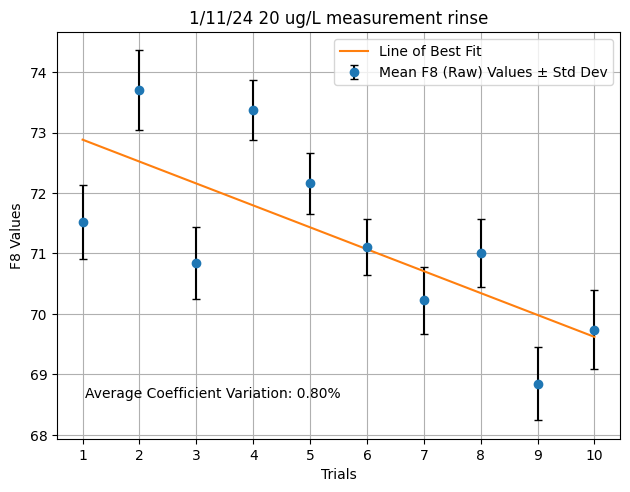

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, t
from sklearn.metrics import r2_score, mean_squared_error

# Replace with the actual file path
file_path = "/Users/jessiewynne/chla_fluorometer/AS7341 Single Concentration Test/1_11_24_700ms_256x_rinse_1.csv"
# Read the CSV file without skipping any rows

df = pd.read_csv(file_path, encoding='utf-8')

# Filter out rows where the 'Test' column is 'test'
df = df[df['Test'].str.lower() != 'test'] 

# Convert 'F8 (Raw)' column to numeric values
df['F8 (Raw)'] = pd.to_numeric(df['F8 (Raw)'], errors='coerce')

# Get unique test categories (dilution values) in the order of appearance
categories = df['Test'].unique()

# Create a dictionary to store the 'F8 (Raw)' values for each category (dilution)
category_f8_raw_dict = {}

# Create dictionaries to store confidence intervals and ranges of uncertainty
confidence_intervals = {}
uncertainty_ranges = {}

# Initialize mean_blank before the loop
mean_blank = 0.0

# Store unique x-values and their corresponding data points
x_values = []
y_values = []
std_devs = []
cv_values = []

for category in categories:
    # Exclude the first data point from each category
    category_df = df[df['Test'] == category][1:]
    category_f8_raw_dict[category] = category_df['F8 (Raw)']

    # Calculate the mean and standard deviation for 'F8 (Raw)' data in each category
    category_f8_raw_mean = category_df['F8 (Raw)'].mean()
    category_f8_raw_std = category_df['F8 (Raw)'].std()
    # print(category_f8_raw_mean)
    # Calculate Coefficient of Variation
    cv = (category_f8_raw_std / category_f8_raw_mean) * 100

    # Calculate the sample size for each category
    category_sample_size = len(category_df['F8 (Raw)'])

    # Calculate the standard error for each category's mean
    category_standard_error = category_f8_raw_std / np.sqrt(category_sample_size)

    # Define the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error using the t-distribution
    margin_of_error = t.ppf((1 + confidence_level) / 2, category_sample_size - 1) * category_standard_error

    # Calculate the confidence interval for each category's mean
    confidence_interval = (category_f8_raw_mean - margin_of_error, category_f8_raw_mean + margin_of_error)

    # Calculate the range of uncertainty (95% CI width) for each category
    uncertainty_range = confidence_interval[1] - confidence_interval[0]

    # Check if the 'Test' value can be converted to a float, otherwise, skip it
    try:
        x_value = float(category)
        x_values.append(x_value)
        y_values.append(category_f8_raw_mean)
        std_devs.append(category_f8_raw_std)
        cv_values.append(cv)
    except ValueError:
        pass
# Calculate the mean and standard deviation for the entire dataset for 'F8 (Raw)' data
dataset_f8_raw_mean = df['F8 (Raw)'].mean()
dataset_f8_raw_std = df['F8 (Raw)'].std()

# Calculate the sample size for the entire dataset
dataset_sample_size = len(df['F8 (Raw)'])

# Calculate the standard error for the entire dataset's mean
dataset_standard_error = dataset_f8_raw_std / np.sqrt(dataset_sample_size)

# Calculate the margin of error using the t-distribution
confidence_level = 0.95
margin_of_error = t.ppf((1 + confidence_level) / 2, dataset_sample_size - 1) * dataset_standard_error

# Calculate the confidence interval for the entire dataset's mean
confidence_interval = (dataset_f8_raw_mean - margin_of_error, dataset_f8_raw_mean + margin_of_error)

# Calculate the range of uncertainty (95% CI width) for the entire dataset
uncertainty_range = confidence_interval[1] - confidence_interval[0]

# Calculate the minimum and maximum 'F8 (Raw)' values for each test category
min_f8_values = {}
max_f8_values = {}
for category, f8_raw_values in category_f8_raw_dict.items():
    min_f8_values[category] = f8_raw_values.min()
    max_f8_values[category] = f8_raw_values.max()

# Scatter plot for mean F8 values with error bars and legend
plt.errorbar(x_values, y_values, yerr=std_devs, fmt='o', capsize=3, ecolor='black', label='Mean F8 (Raw) Values ± Std Dev')

# Calculate the line of best fit parameters (slope and intercept)
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Create a function to calculate predicted values using the line of best fit equation
def predict_values(x, slope, intercept):
    return slope * x + intercept

# Plot the line of best fit
plt.plot(x_values, predict_values(np.array(x_values), slope, intercept), label='Line of Best Fit')

# Display average Coefficient of Variation on the plot
avg_cv = np.mean(cv_values)
plt.annotate(f'Average Coefficient Variation: {avg_cv:.2f}%', xy=(0.05, 0.10), xycoords='axes fraction')

# # Calculate R-squared and RMSE
# y_predicted = predict_values(np.array(x_values), slope, intercept)
# r_squared = r2_score(y_values, y_predicted)
# rmse = np.sqrt(mean_squared_error(y_values, y_predicted))

# Set x-axis tick positions at intervals of 1
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1))

# # Display R-squared and RMSE on the plot
# plt.annotate(f'R-squared: {r_squared:.4f}\nRMSE: {rmse:.4f}', xy=(0.05, 0.85), xycoords='axes fraction')

plt.tight_layout()

plt.xlabel('Trials')
plt.ylabel('F8 Values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("1/11/24 20 ug/L measurement rinse")
plt.show()
